2024-06-14 15:02:13.071016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 15:02:14.312708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(204, 256, 256, 14) (204, 256, 256, 1) (51, 256, 256, 14) (51, 256, 256, 1)
1.0 0.0 float32
(816, 256, 256, 14) (816, 256, 256, 1)


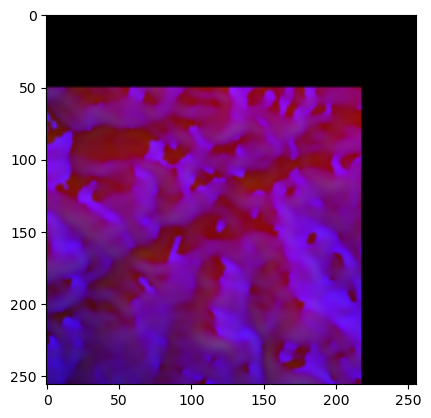

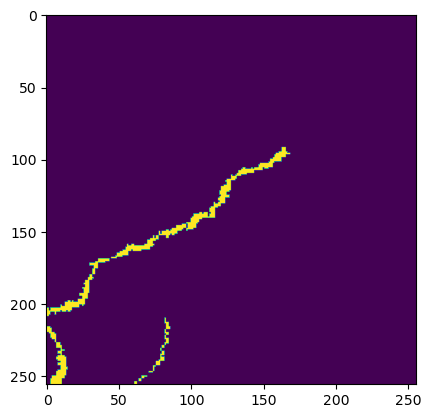

Class weights tensor: tf.Tensor([0.5419614 6.457859 ], shape=(2,), dtype=float32)


2024-06-14 15:02:35.751905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      4,064 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     36,928 │ conv2d_7[0][0]  

 Total params: 412,449 (1.57 MB)

 Trainable params: 412,449 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.5994 
Epoch 1: val_loss improved from inf to 0.58374, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 152s 11s/step - loss: 0.5985 - val_loss: 0.5837
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.5015 
Epoch 2: val_loss improved from 0.58374 to 0.46391, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - loss: 0.5002 - val_loss: 0.4639
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.3759 
Epoch 3: val_loss improved from 0.46391 to 0.38843, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - loss: 0.3752 - val_loss: 0.3884
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.3302 
Epoch 4: val_loss improved from 0.38843 to 0.33510, saving model to output/best_weight.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - loss: 0.3289 - val_loss: 0.3351
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.2836 
Ep

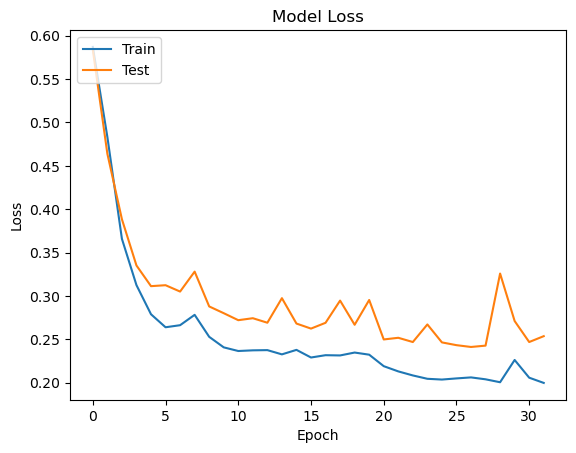

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
(51, 256, 256, 1)


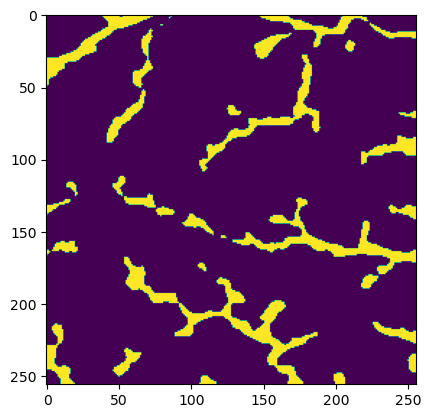

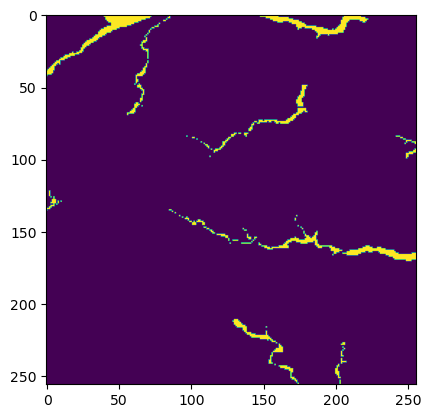

(0.3259583555054906, 0.912024750441109, 0.48026840819734523, 0.31602186253670417)
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
(72, 256, 256, 1)


'output/file.shp'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from sklearn.utils import class_weight
from geotile import GeoTile, mosaic, vectorize

# Load configuration
with open('config.yaml') as f:
    config = yaml.safe_load(f)

x_train_path = config['paths']['x_train']
y_train_path = config['paths']['y_train']
x_test_path = config['paths']['x_test']
y_test_path = config['paths']['y_test']
best_model_path = config['paths']['best_model']
prediction_tiles_path = config['paths']['prediction_tiles']
merged_raster_output = config['paths']['merged_raster_output']
vectorized_output = config['paths']['vectorized_output']
raster_input = config['paths']['raster_input']

# Load initial data
train_xx = np.load(x_train_path)
train_yy = np.load(y_train_path)

# Split data into training and test sets
train_xx_initial, test_xx, train_yy_initial, test_yy = train_test_split(train_xx, train_yy, test_size=0.2, random_state=42)
np.save(x_test_path, test_xx)
np.save(y_test_path, test_yy)
print(train_xx_initial.shape, train_yy_initial.shape, test_xx.shape, test_yy.shape)

# Data augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Flipud(0.5), 
    iaa.Affine(rotate=(-45, 45)), 
    iaa.Affine(scale=(0.5, 1.5)), 
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
])

augmented_images, augmented_masks = [], []
num_augmentations = 3

for i in range(train_xx_initial.shape[0]):
    image, mask = train_xx_initial[i], train_yy_initial[i]
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    for _ in range(num_augmentations):
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Append augmented data to original data
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)
del augmented_images, augmented_masks

print(train_xx.max(), train_xx.min(), train_xx.dtype)
print(train_xx.shape, train_yy.shape)

num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)
train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

# Plot a sample input RGB image and output image with buildings
img = np.random.randint(0, 10)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

# Calculate class weights
train_labels_flat = train_yy_initial.flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
print("Class weights tensor:", class_weights_tensor)

@tf.keras.utils.register_keras_serializable()
def custom_weighted_loss(class_weights_tensor):
    def loss(y_true, y_pred):
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])
        epsilon = tf.keras.backend.epsilon()
        y_pred_flat = tf.clip_by_value(y_pred_flat, epsilon, 1 - epsilon)
        loss = - (y_true_flat * tf.math.log(y_pred_flat) + (1 - y_true_flat) * tf.math.log(1 - y_pred_flat))
        weights = tf.gather(class_weights_tensor, tf.cast(y_true_flat, tf.int32))
        weighted_loss = loss * weights
        return tf.reduce_mean(weighted_loss)
    return loss

# Build the model
x_in = Input(shape=(256, 256, 14))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=custom_weighted_loss(class_weights_tensor), optimizer='adam')
model.summary()

# Train the model
checkpointer = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
callbacks = [earlyStopping, checkpointer]

history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=50, batch_size=64, verbose=1, callbacks=callbacks)

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
model = load_model(best_model_path)

threshold = 0.5
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

img = np.random.randint(0, 20)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(test_yy[img,:,:,0])
plt.show()

test_yy = test_yy.astype('uint8')
pred_test = pred_test.astype('uint8')

def calculate_metrics(ground_truth, predicted_mask):
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    iou = TP / (TP + FP + FN)

    return precision, recall, f1_score, iou

print(calculate_metrics(test_yy, pred_test))

# GeoTile operations
gt = GeoTile(raster_input)
gt.meta

gt.generate_tiles(save_tiles=False, stride_x=256, stride_y=256)
gt.convert_nan_to_zero()
gt.normalize_tiles()

threshold = 0.5
pred_test = model.predict(gt.tile_data)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

gt.tile_data = pred_test
gt.save_tiles(prediction_tiles_path)

mosaic(prediction_tiles_path, merged_raster_output)
vectorize(merged_raster_output, vectorized_output, raster_values=[1])
